## 1. PURPOSE

Our main aim is to build a model to determine whether a game stops or continues.

Detailed info on features and their calculations can be found on classes.FeatureBuilder. Target data is derived from a player who owns the ball. So if some player has the ball then we labelled it as 'game-play', if no one has the ball then we labelled it as 'game-stop'. This approach has some disadvantages. During typical long passing when the ball changes its location, we don't have information of the ball locations. This will cause some biases on learning. 

In [2]:
import pandas as pd
import numpy as np
from keras.models import load_model
from keras.utils import to_categorical
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

# nn trainer class
from classes.NNBuilder import *
# utility functions
from classes.Utils import *

#### Get data

In [2]:
# get dataset
try:
    train_df = pd.read_csv('dataset/data_train.csv').dropna().reset_index(drop=True)
except FileNotFoundError:
    raise FileNotFoundError

In [3]:
# get values
X_train = train_df.iloc[:, 7:].values
y_train = train_df['game_state'].values
del train_df

In [4]:
# shuffle data
X_train, y_train = shuffle(X_train, y_train)

In [4]:
# scale values 
scaler = StandardScaler().fit(X_train)
X_train=scaler.transform(X_train)

## 2. TRAIN & OPTIMIZING

In this part training and parameters search for best nn structure will be conducted. Best parameters will be defined by comparing accuracy on validation set.

In [119]:
## NN STRUCTURES 
nn_structures = {
    
    
# create the desired nn structur
# in the next stage, we only assig value to parameters those have null value 
    
                0:{'input': { 'layer': None, 'activation': None},
                'dropout0': {'ratio': 0.2},
                'hidden0':  { 'layer': None, 'activation': None},
                'output':   { 'layer': 1, 'activation': None}},
                    
                1:{'input': { 'layer': None, 'activation': None},
                'dropout0':  {'ratio': 0.2},
                'hidden0':  { 'layer': None, 'activation': None},
                'hidden1':  { 'layer': None, 'activation': None},
                'output':   { 'layer': 1, 'activation': None}},
                
                2:{'input': { 'layer': None, 'activation': None},
                'dropout0': {'ratio': 0.2},
                'hidden0':  { 'layer': None, 'activation': None},
                'hidden1':  { 'layer': None, 'activation': None},
                'hidden2':  { 'layer': None, 'activation': None},
                'output':   { 'layer': 1, 'activation': None}},
    
                3:{'input': { 'layer': None, 'activation': None},
                'dropout0': {'ratio': 0.2},
                'hidden0':  { 'layer': None, 'activation': None},
                'hidden1':  { 'layer': None, 'activation': None},
                'hidden2':  { 'layer': None, 'activation': None},
                'hidden3':  { 'layer': None, 'activation': None},
                'output':   { 'layer': 1, 'activation': None}}
                
                }

In [120]:
# PARAMS GIRD
param_grid = [
    {      
            'dense': [70, 130, 240],
            'activation': ['sigmoid', 'relu'],
            'optimizer': ['adam','Adadelta']
    }
]


# CREATE ITERATIVE PARAM LIST
para_label=['dense', 'activation', 'optimizer']

# parameter list for storing all possible combinations
param_list = []

# create all possible parameters combinations for optimizations
for n_dense in param_grid[0]['dense']:
        for n_act in param_grid[0]['activation']:
            for n_opt in param_grid[0]['optimizer']:
                param_dict = dict(zip(para_label, [n_dense, n_act, n_opt]))
                param_list.append(param_dict)

In [126]:
# select the model with best (last) validation accuracy on train data

tmp_val_acc = 0
best_model = None
best_model_params = {}
best_model_history = None

# iterate through nn_strcuture
nn_structures_loop = nn_structures

for nn_key , nn_value in nn_structures_loop.items():
    
    # ----------------- GET PARAMETERS -----------------

    # iterate through parameters   
    for param_i,_ in enumerate(param_list):
                
        # get paramas
        dense_p = param_list[param_i]['dense']
        activation_p = param_list[param_i]['activation']
        optimizer_p = param_list[param_i]['optimizer']
        
        # set current nn_structure
        for nn_inner_key , nn_inner_value in nn_value.items():
            try:
                
                if 'layer' in nn_inner_value and nn_inner_key!='output':
                    nn_inner_value['layer']=dense_p
                if 'activation' in nn_inner_value:
                    nn_inner_value['activation']=activation_p
                    
            except KeyError:
                pass

        
        # ----------------- TRAIN MODEL -----------------
        
        nnBuilder = NNBuilder(input_shape = X_train.shape[1]) # init nn builder

        nnBuilder.init_model(nn_value) # init model
        model=nnBuilder.get_model() # get model

        # compile model parameters
        model.compile(optimizer=optimizer_p, loss='binary_crossentropy', metrics=['accuracy'])

        # train and get history
        hist = model.fit(X_train, y_train, epochs=32, batch_size=32, validation_split=0.10, verbose=0)
            
        # set pest params
        if hist.history['val_acc'][-1]>tmp_val_acc:
            tmp_val_acc = hist.history['val_acc'][-1]
            best_model_params = {'nn':nn_value, 'optimizer':optimizer_p}
            best_model_history = hist
            best_model = model
        
        # Deletes the existing model
        del model
        del nnBuilder
        
del X_train, y_train

# save model
best_model.save('models/{path}/{model}.h5'.format(path='nn', model=('game_state_clf')))
del best_model

## 3. RESULTS

#### Result of gird search

In [122]:
# best nn strucutre
best_model_params

{'nn': {'input': {'layer': 240, 'activation': 'relu'},
  'dropout0': {'ratio': 0.2},
  'hidden0': {'layer': 240, 'activation': 'relu'},
  'hidden1': {'layer': 240, 'activation': 'relu'},
  'output': {'layer': 1, 'activation': 'relu'}},
 'optimizer': 'adam'}

#### Train set

In [9]:
print('accuracy: {}'.format(str(round(best_model_history.history['acc'][-1]*100, 2))))
print('loss: {}'.format(str(round(best_model_history.history['loss'][-1]*100, 2))))

accuracy: 87.78
loss: 30.45


#### Validation set

In [11]:
print('accuracy: {}'.format(str(round(best_model_history.history['val_acc'][-1]*100, 2))))
print('loss: {}'.format(str(round(best_model_history.history['val_loss'][-1]*100, 2))))

accuracy: 87.44
loss: 31.76


#### Model History

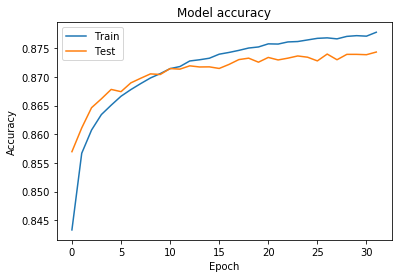

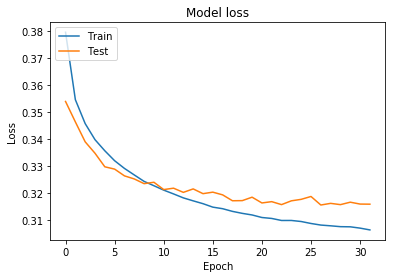

{'input': {'layer': 240, 'activation': 'relu'}, 'dropout0': {'ratio': 0.2}, 'hidden0': {'layer': 240, 'activation': 'relu'}, 'hidden1': {'layer': 240, 'activation': 'relu'}, 'output': {'layer': 1, 'activation': 'relu'}}
adam


In [127]:
# draw train histry
plot_model_history(best_model_history, title='Model accuracy', val_label=['acc', 'val_acc'])
plot_model_history(best_model_history, title='Model loss', val_label=['loss','val_loss'])

# print best params
for _, values in best_model_params.items():
    print(values)

### Summary of training phase result
Although the convergence of model accuracy and loss on both training and validation sets show no sign of overfitting or underfitting, both training and validation sets have a high loss rate, with over 30%. Why is that?

The main reason for this is the insufficiency of raw data. We can only dedicate target data if some player has the ball at the moment. So what happens when no one has the ball? Does the game continue, as it's in passing? During a pass, no player owns the ball. Therefore, we have no information on a significant amount of data frames when the ball passes from one player to another. This causes serious losses in our model, as our feature set is highly depended on speed derived elements. Normally, players' activities, especially their individual and group speeds, reach the minimum when the game stop. In short, game stop players stop too. However, during the ball passing in which we have no information on ball location, the game continues and the players are not in their minimum activity state. Thus, model fails to generalize these states. The solution to this problem is not covered in this project.

### Result on the test set
The results are examined on 31 unseen matches.

In [13]:
# get test dataset
try:
    test_df = pd.read_csv('dataset/data_test.csv').dropna().reset_index(drop=True)
except FileNotFoundError:
    raise FileNotFoundError

In [14]:
# get values
X_test = test_df.iloc[:, 7:].values
y_test = test_df['game_state'].values
del test_df

In [15]:
# shuffle data
X_test, y_test = shuffle(X_test, y_test)

In [16]:
X_test = scaler.transform(X_test)

In [17]:
# Load model
model = load_model('models/nn/game_state_clf.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 240)               72000     
_________________________________________________________________
dropout_25 (Dropout)         (None, 240)               0         
_________________________________________________________________
dense_82 (Dense)             (None, 240)               57840     
_________________________________________________________________
dense_83 (Dense)             (None, 240)               57840     
_________________________________________________________________
dense_84 (Dense)             (None, 1)                 241       
Total params: 187,921
Trainable params: 187,921
Non-trainable params: 0
_________________________________________________________________


In [20]:
score = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[0], score[0]*100))
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

loss: 37.29%
acc: 85.00%
